In [37]:
# Standard imports
import copy
import corner
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import display, Markdown, Math
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Astropy imports
from astropy.io import fits
from astropy import units as u
from astropy.table import Table
from astropy.units import Quantity
from astropy import constants as const
from astropy.cosmology import FlatLambdaCDM

# SLSim imports
import slsim.Pipelines as pipelines
import slsim.Sources as sources
import slsim.Deflectors as deflectors
from slsim.Lenses.lens_pop import LensPop
from slsim.Plots.lens_plots import LensingPlots
from slsim.Lenses.lens import Lens
from slsim.LOS.los_pop import LOSPop

# Lenstronomy, HierArc imports
from lenstronomy.LensModel.lens_model import LensModel
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam

from ltsfit.ltsfit import ltsfit

In [46]:
Auger_2010 = Table.read("../data/external_catalogs/Auger_2010.csv", format='ascii.csv')

# Sigma_e/2
Auger_2010['log(Sigma_e/2/Msun/pc2)'] = np.log10(
    (10**(Auger_2010['log(M_re/2/Msun)']))/np.pi / (Auger_2010['r_e_V(kpc)']*1e3)**2
    )

# error on Sigma_e/2
Auger_2010['sig_log(Sigma_e/2/Msun/pc2)'] = Auger_2010['sig_log(M_re/2/Msun)']


# Make columns with standard names
Auger_2010['log(Sigma_1/2)'] = np.log10((10**Auger_2010["log(Sigma_e/2/Msun/pc2)"])*1e6/1e10)  # Convert to 1e10Msun/kpc^2
Auger_2010['sig_log(Sigma_1/2)'] = Auger_2010['sig_log(Sigma_e/2/Msun/pc2)']
Auger_2010['log(sigma_1/2)'] = np.log10(Auger_2010['sigma_e/2(km/s)']/250)  # Convert to log10
Auger_2010['sig_log(sigma_1/2)'] = Auger_2010['sigma_e/2(km/s)']/250 / (Auger_2010["sigma_e/2(km/s)"]/250) / np.log(10)
Auger_2010['log(r_e)'] = np.log10(Auger_2010['r_e_V(kpc)'])  # Convert to log10


Auger_2010

Lens_Name,r_e_V(kpc),sigma_e/2(km/s),sig_sigma_e/2(km/s),log(M*/Msun)_Chab,sig_log(M*/Msun)_Chab,log(M*/Msun)_Salp,sig_log(M*/Msun)_Salp,log(M_re/2/Msun),sig_log(M_re/2/Msun),f_DM_Chab,sig_f_DM_Chab,f_DM_Salp,sig_f_DM_Salp,gamma_prime_PL,sig_gamma_prime_PL,log(Sigma_e/2/Msun/pc2),sig_log(Sigma_e/2/Msun/pc2),log(Sigma_1/2),sig_log(Sigma_1/2),log(sigma_1/2),sig_log(sigma_1/2),log(r_e)
str14,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
SDSSJ0029-0055,8.36,231,18,11.33,0.13,11.58,0.13,11.13,0.03,0.47,0.15,0.04,0.28,2.38,0.23,2.788437572427834,0.03,-1.211562427572166,0.03,-0.03432802877989328,0.43429448190325176,0.9222062774390164
SDSSJ0037-0942,7.44,282,10,11.48,0.06,11.73,0.06,11.36,0.02,0.57,0.07,0.25,0.11,2.14,0.07,3.119704256214108,0.02,-0.8802957437858917,0.02,0.05230909964732344,0.43429448190325176,0.8715729355458788
SDSSJ0044+0113,6.12,267,13,11.23,0.09,11.47,0.09,11.13,0.07,0.59,0.1,0.29,0.18,2.31,0.24,3.0593472830147443,0.07,-0.9406527169852557,0.07,0.028571252692537637,0.43429448190325176,0.7867514221455612
SDSSJ0216-0813,13.19,334,23,11.79,0.07,12.03,0.07,11.76,0.02,0.65,0.06,0.4,0.11,2.09,0.2,3.0223605362131356,0.02,-0.9776394637868644,0.02,0.1258064581395269,0.43429448190325176,1.1202447955463652
SDSSJ0252+0039,5.68,170,12,11.21,0.13,11.46,0.13,10.97,0.03,0.42,0.18,-0.03,0.32,1.57,0.12,2.964153455883829,0.03,-1.035846544116171,0.03,-0.16749108729376366,0.43429448190325176,0.7543483357110189
SDSSJ0330-0020,6.23,220,21,11.35,0.09,11.58,0.09,11.14,0.05,0.46,0.12,0.09,0.21,1.91,0.18,3.0538740339875274,0.05,-0.9461259660124726,0.05,-0.05551732784983137,0.43429448190325176,0.7944880466591696
SDSSJ0728+3835,5.86,219,11,11.44,0.12,11.69,0.12,11.12,0.02,0.31,0.19,-0.23,0.37,1.86,0.1,3.087054895269684,0.02,-0.9129451047303161,0.02,-0.05749589383191927,0.43429448190325176,0.7678976160180907
SDSSJ0737+3216,14.1,338,16,11.72,0.07,11.96,0.07,11.52,0.03,0.49,0.09,0.1,0.16,2.68,0.12,2.724411901995106,0.03,-1.275588098004894,0.03,0.13097669160561715,0.43429448190325176,1.14921911265538
SDSSJ0819+4534,7.63,227,15,11.15,0.08,11.4,0.08,11.16,0.04,0.68,0.07,0.43,0.12,2.16,0.25,2.8978010513961054,0.04,-1.1021989486038946,0.04,-0.04191415147891488,0.43429448190325176,0.8825245379548805


sig_int:     0.0000      0.0257
Computing sig_int
sig_int:     0.0000      0.0257
sig_int:     0.0995     -0.7660
sig_int:     0.0032      0.0222
sig_int:     0.0229     -0.1243
sig_int:     0.0062      0.0128
sig_int:     0.0099     -0.0064
sig_int:     0.0087      0.0009
sig_int:     0.0088      0.0000
sig_int:     0.0088     -0.0000
Computing sig_int error
sig_int:     0.0088      0.1943
sig_int:     0.0995     -0.5698
sig_int:     0.0319     -0.0322
sig_int:     0.0286      0.0058
sig_int:     0.0291      0.0000
sig_int:     0.0291     -0.0002
Repeating at best fitting solution
sig_int:     0.0088     -0.0000

################# Values and formal errors ################

        a =  -0.336 +/- 0.049
      b_0 =  1.86 +/- 0.12
      b_1 =  -1.272 +/- 0.055
  scatter =  0.009 +/- 0.020
Observed rms scatter: 0.0772
y = a + (x_0 - p_0) b_0 + (x_1 - p_1) b_1
   p_0 = 0.000
   p_1 = 0.000
Adopted clip = 2.60*sigma; Fitted/Clipped = 56/3
Non-clipped Spearman r = 0.92 and p = 1.2e-24
Non-c

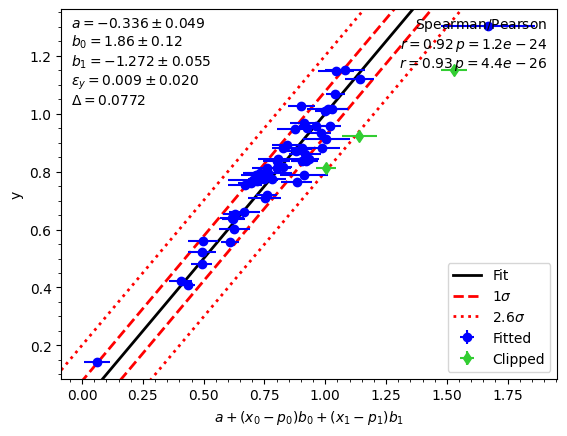

In [31]:
x1 = np.log10(Auger_2010["sigma_e/2(km/s)"]/250)
x2 = np.log10((10**Auger_2010["log(Sigma_e/2/Msun/pc2)"])*1e6/1e10)  # Convert to 1e10Msun/kpc^2
y = np.log10(Auger_2010["r_e_V(kpc)"])

x1_err = Auger_2010['sig_sigma_e/2(km/s)']/250 / (Auger_2010["sigma_e/2(km/s)"]/250) / np.log(10)
x2_err = Auger_2010['sig_log(Sigma_e/2/Msun/pc2)']
y_err = np.zeros_like(y)  # No error on r_e_V

#arrays
x1, x2, y = np.array(x1), np.array(x2), np.array(y)

x = np.column_stack([x1, x2])
sigx = np.column_stack([x1_err, x2_err])
sigy = y_err

p = ltsfit(x, y, sigx, sigy, corr=True, epsy=True, clip = 2.6,
           frac=None, label='Fitted',
           legend=True,plot=True, text=True)

print(f"Best fitting parameters: {p.coef}")
print(f"Scatter in log r_e: {p.sig_int} dex")
print(f"Scatter in r_e: {p.sig_int*np.log(10)*100:.2f}  +- {p.sig_int_err*np.log(10)*100:.2f} %")

sig_int:     0.0000      0.0257
Computing sig_int
sig_int:     0.0000      0.0257
sig_int:     0.0533     -0.7980
sig_int:     0.0017      0.0225
sig_int:     0.0128     -0.0219
sig_int:     0.0073     -0.0330
sig_int:     0.0039      0.0077
sig_int:     0.0049     -0.0019
sig_int:     0.0047      0.0001
sig_int:     0.0047      0.0000
sig_int:     0.0047     -0.0000
Computing sig_int error
sig_int:     0.0047      0.1943
sig_int:     0.0533     -0.5980
sig_int:     0.0166     -0.0184
sig_int:     0.0156      0.0033
sig_int:     0.0158      0.0000
sig_int:     0.0158     -0.0002
Repeating at best fitting solution
sig_int:     0.0047      0.0000

################# Values and formal errors ################

        a =  0.180 +/- 0.028
      b_0 =  0.535 +/- 0.033
      b_1 =  0.680 +/- 0.051
  scatter =  0.005 +/- 0.011
Observed rms scatter: 0.0414
y = a + (x_0 - p_0) b_0 + (x_1 - p_1) b_1
   p_0 = 0.000
   p_1 = 0.000
Adopted clip = 2.60*sigma; Fitted/Clipped = 56/3
Non-clipped Spearma

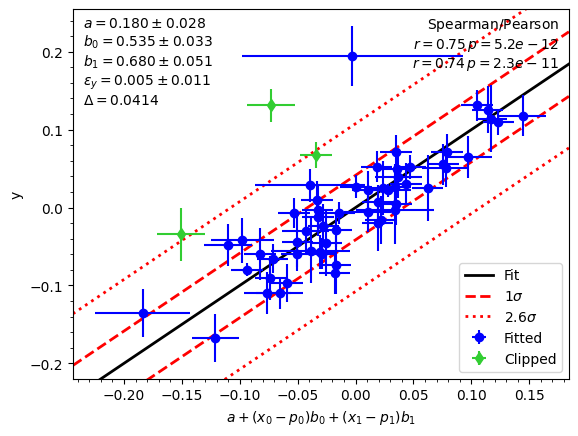

In [30]:
x1 = np.log10(Auger_2010["r_e_V(kpc)"])
x2 = np.log10((10**Auger_2010["log(Sigma_e/2/Msun/pc2)"])*1e6/1e10)  # Convert to 1e10Msun/kpc^2
y = np.log10(Auger_2010["sigma_e/2(km/s)"]/250)

x1_err = np.zeros_like(y)  # No error on r_e_V
x2_err = Auger_2010['sig_log(Sigma_e/2/Msun/pc2)']
y_err = Auger_2010['sig_sigma_e/2(km/s)']/250 / (Auger_2010["sigma_e/2(km/s)"]/250) / np.log(10)

#arrays
x1, x2, y = np.array(x1), np.array(x2), np.array(y)

x = np.column_stack([x1, x2])
sigx = np.column_stack([x1_err, x2_err])
sigy = y_err

p = ltsfit(x, y, sigx, sigy, corr=True, epsy=True, clip = 2.6,
           frac=None, label='Fitted',
           legend=True,plot=True, text=True)

print(f"Best fitting parameters: {p.coef}")
print(f"Scatter in log sigma_v: {p.sig_int} dex")
print(f"Scatter in sigma_v: {p.sig_int*np.log(10)*100:.2f} +- {p.sig_int_err*np.log(10)*100:.2f} %")

In [52]:
Pritom2025 = Table.read(
    "../data/external_catalogs/Pritom_2025.csv", 
)
gammas_to_use = 'SIS'  # or 'SIS' for Singular Isothermal Sphere (SIS) assumption

## compute the avg. lensing mass density within the half-light radius

# first compute the lensing mass within einstein radius using the formula:
# M_lens_E = (c^2 / 4 * G) * theta_E^ 2 * D_L * D_S / D_LS

cosmo_true = FlatLambdaCDM(H0=70, Om0=0.3)

D_L = cosmo_true.angular_diameter_distance(np.array(Pritom2025["z_lens"]))
D_S = cosmo_true.angular_diameter_distance(np.array(Pritom2025["z_source"]))
D_LS = cosmo_true.angular_diameter_distance_z1z2(
    np.array(Pritom2025["z_lens"]), np.array(Pritom2025["z_source"])
)

# convert theta_E from arcsec to radian
theta_E_rad = np.array(Pritom2025["theta_E_arcsec"])*u.arcsec.to(u.rad)  # convert arcsec to radian
sig_theta_E_rad = np.array(Pritom2025["sig_theta_E_arcsec"])*u.arcsec.to(u.rad)  # convert arcsec to radian

# compute the lensing mass within the einstein radius
M_lens_E = (const.c**2 / (4 * const.G)) * theta_E_rad**2 * D_L * D_S / D_LS
M_lens_E = M_lens_E.to(u.Msun)

# NOTE: For SIE Sigma = Sigma_E (R / R_E)^(1 - gamma)

# avg. lensing mass density within the einstein radius
Sigma_E = M_lens_E / (np.pi * (D_L * theta_E_rad)**2)
Sigma_E = Sigma_E.to(u.Msun / u.pc**2)

# avg. lensing mass density within the half-light radius
R_eff_rad = np.array(Pritom2025['R_eff_arcsec']) * u.arcsec.to(u.rad)  # convert arcsec to radian
R_eff_kpc = R_eff_rad * D_L.to(u.kpc)  # convert to kpc

if gammas_to_use == 'GIVEN':
    Sigma_eff = Sigma_E * (R_eff_rad/2 / theta_E_rad)**(1 - np.array(Pritom2025['gamma_lens']))

    sig_log_Sigma_eff = (np.array(Pritom2025['gamma_lens']) - 1)*Pritom2025['sig_theta_E_arcsec']/Pritom2025['theta_E_arcsec']/ np.log(10)
if gammas_to_use == 'SIS':
    Sigma_eff = Sigma_E * (R_eff_rad/2 / theta_E_rad)**(1 - 2)  # assuming gamma = 2
    sig_log_Sigma_eff = (2 - 1)*Pritom2025['sig_theta_E_arcsec']/Pritom2025['theta_E_arcsec']/ np.log(10)

Sigma_eff = Sigma_eff.to(u.Msun / u.pc**2)

# add the computed values to the table
Pritom2025['Sigma_eff_Msun_pc2'] = Sigma_eff.value
Pritom2025['log(Sigma_eff_10^10Msun_kpc2)'] = np.log10(Sigma_eff.value * 1e6/1e10)  # Convert to 1e10Msun/kpc^2
Pritom2025['sig_log(Sigma_eff_10^10Msun_kpc2)'] = sig_log_Sigma_eff
Pritom2025['R_eff_kpc'] = R_eff_kpc.value



# Make columns with standard names
Pritom2025['log(Sigma_1/2)'] = Pritom2025['log(Sigma_eff_10^10Msun_kpc2)']
Pritom2025['sig_log(Sigma_1/2)'] = Pritom2025['sig_log(Sigma_eff_10^10Msun_kpc2)']
Pritom2025['log(sigma_1/2)'] = np.log10(Pritom2025['sigma_half_km_s']/250)  # Convert to log10
Pritom2025['sig_log(sigma_1/2)'] = Pritom2025['sig_sigma_half_km_s']/250 / (Pritom2025["sigma_half_km_s"]/250) / np.log(10)
Pritom2025['log(r_e)'] = np.log10(Pritom2025['R_eff_kpc'])  # Convert to log10



Pritom2025

Name,Survey,z_lens,z_source,R_eff_arcsec,theta_E_arcsec,sig_theta_E_arcsec,sigma_half_km_s,sig_sigma_half_km_s,gamma_lens,sig_gamma_lens,Sigma_eff_Msun_pc2,log(Sigma_eff_10^10Msun_kpc2),sig_log(Sigma_eff_10^10Msun_kpc2),R_eff_kpc,log(Sigma_1/2),sig_log(Sigma_1/2),log(sigma_1/2),sig_log(sigma_1/2),log(r_e)
str23,str5,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
SL2SJ021411-040502,SL2S,0.609,1.88,0.42,1.34,0.03,219,10,2.39,0.2,13811.032572022377,0.1402261495103769,0.00972301078887877,2.8272288972396407,0.1402261495103769,0.00972301078887877,-0.05749589383191927,0.019830798260422455,0.4513609711297168
SL2SJ021902-082934,SL2S,0.389,2.15,0.39,1.3,0.03,303,10,2.7,0.11,14148.69073265601,0.1507162537196421,0.010022180351613503,2.059912765358908,0.1507162537196421,0.010022180351613503,0.0835026198302674,0.014333151217929104,0.3138488289490334
SL2SJ022610-042011,SL2S,0.494,1.23,0.39,1.15,0.02,324,15,2.05,0.15,15318.400466938738,0.1852134190401114,0.007552947511360901,2.365307203685946,0.1852134190401114,0.007552947511360901,0.11260500153457455,0.020106226014039434,0.37388755446124194
SL2SJ023251-040823,SL2S,0.352,2.34,0.32,1.02,0.02,221,5,2.38,0.18,13736.426152328635,0.13787375570658006,0.00851557807653435,1.5865800122785674,0.13787375570658006,0.00851557807653435,-0.05354773498692691,0.009825667011385786,0.2004619787464511
SL2SJ084909-041226,SL2S,0.722,1.54,0.24,1.14,0.03,363,16,2.07,0.15,25153.677481760893,0.4006014881307603,0.011428802155348732,1.735999036698958,0.4006014881307603,0.011428802155348732,0.1619666163640749,0.019142456502622668,0.23954947985173863
SL2SJ084959-025142,SL2S,0.274,2.09,1.54,1.19,0.01,207,3,2.24,0.3,3759.2909798357127,-0.4248940573545213,0.0036495334613718643,6.435796316615627,-0.4248940573545213,0.0036495334613718643,-0.08196966321511988,0.006294122926134084,0.8086022908698657
SL2SJ085540-014730,SL2S,0.365,3.39,0.47,0.96,0.02,203,11,2.25,0.11,8246.88871191983,-0.083709866007407,0.009047801706317747,2.385222351525685,-0.083709866007407,0.009047801706317747,-0.09044397075882467,0.02353319852677719,0.37752887039480887
SL2SJ090407-005952,SL2S,0.611,2.36,0.71,1.41,0.03,238,9,1.98,0.15,7861.206859721033,-0.10451077555314131,0.009240308125601102,4.786529148030349,-0.10451077555314131,0.009240308125601102,-0.021363051615525673,0.016422900576173387,0.6800207079353288
SL2SJ095921+020638,SL2S,0.552,3.35,0.41,0.71,0.02,209,8,2.12,0.18,6283.6970289743085,-0.20178476281357963,0.01223364737755639,2.633507877570051,-0.20178476281357963,0.01223364737755639,-0.07779372256098363,0.016623712225961793,0.42053462179358975


sig_int:     0.0000      5.4247
Computing sig_int
sig_int:     0.0000      5.4247
sig_int:     0.1874     -0.7009
sig_int:     0.1660     -0.6232
sig_int:     0.0830      0.2792
sig_int:     0.1087     -0.1846
sig_int:     0.0984     -0.0339
sig_int:     0.0964      0.0010
sig_int:     0.0965     -0.0000
Computing sig_int error
sig_int:     0.0965      0.2425
sig_int:     0.1874     -0.4584
sig_int:     0.1279     -0.1474
sig_int:     0.1160     -0.0308
sig_int:     0.1132      0.0011
sig_int:     0.1133     -0.0000
Repeating at best fitting solution
sig_int:     0.0965     -0.0000

################# Values and formal errors ################

        a =  0.473 +/- 0.024
      b_0 =  1.50 +/- 0.30
      b_1 =  -1.100 +/- 0.076
  scatter =  0.096 +/- 0.017
Observed rms scatter: 0.107
y = a + (x_0 - p_0) b_0 + (x_1 - p_1) b_1
   p_0 = 0.000
   p_1 = 0.000
Adopted clip = 6.00*sigma; Fitted/Clipped = 37/0
Non-clipped Spearman r = 0.92 and p = 6.7e-16
Non-clipped Pearson r = 0.92 and p = 4.

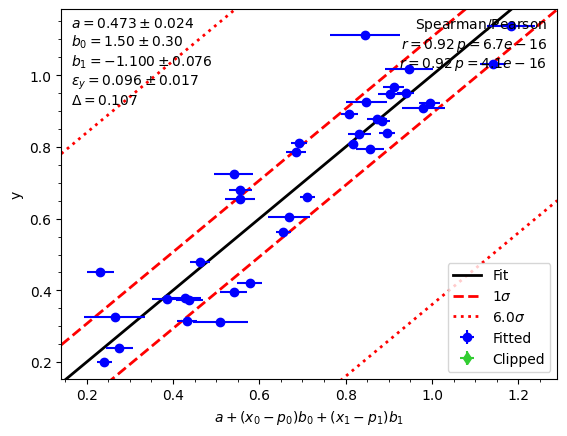

In [53]:
x1 = np.log10(Pritom2025["sigma_half_km_s"]/250)
x2 = Pritom2025['log(Sigma_eff_10^10Msun_kpc2)']  # Already in log10
y = np.log10(Pritom2025["R_eff_kpc"])

x1_err = Pritom2025['sig_sigma_half_km_s']/250 / (Pritom2025["sigma_half_km_s"]/250) / np.log(10)
x2_err = Pritom2025['sig_log(Sigma_eff_10^10Msun_kpc2)']
y_err = np.zeros_like(y)  # No error on r_e_V

#arrays
x1, x2, y = np.array(x1), np.array(x2), np.array(y)

x = np.column_stack([x1, x2])
sigx = np.column_stack([x1_err, x2_err])
sigy = y_err

p = ltsfit(x, y, sigx, sigy, corr=True, epsy=True, clip = 6,
           frac=None, label='Fitted',
           legend=True,plot=True, text=True)

print(f"Best fitting parameters: {p.coef}")
print(f"Scatter in log r_e: {p.sig_int} dex")
print(f"Scatter in r_e: {p.sig_int*np.log(10)*100:.2f}  +- {p.sig_int_err*np.log(10)*100:.2f} %")

In [54]:
from astropy.table import vstack

In [55]:
# fit Auger and Pritom together
Auger_table = copy.deepcopy(Auger_2010)['log(Sigma_1/2)', 'sig_log(Sigma_1/2)', 'log(sigma_1/2)', 'sig_log(sigma_1/2)', 'log(r_e)']
Pritom_table = copy.deepcopy(Pritom2025)['log(Sigma_1/2)', 'sig_log(Sigma_1/2)', 'log(sigma_1/2)', 'sig_log(sigma_1/2)', 'log(r_e)']


combined_table = vstack([Auger_table, Pritom_table])

combined_table

log(Sigma_1/2),sig_log(Sigma_1/2),log(sigma_1/2),sig_log(sigma_1/2),log(r_e)
float64,float64,float64,float64,float64
-1.211562427572166,0.03,-0.03432802877989328,0.43429448190325176,0.9222062774390164
-0.8802957437858917,0.02,0.05230909964732344,0.43429448190325176,0.8715729355458788
-0.9406527169852557,0.07,0.028571252692537637,0.43429448190325176,0.7867514221455612
-0.9776394637868644,0.02,0.1258064581395269,0.43429448190325176,1.1202447955463652
-1.035846544116171,0.03,-0.16749108729376366,0.43429448190325176,0.7543483357110189
-0.9461259660124726,0.05,-0.05551732784983137,0.43429448190325176,0.7944880466591696
-0.9129451047303161,0.02,-0.05749589383191927,0.43429448190325176,0.7678976160180907
-1.275588098004894,0.03,0.13097669160561715,0.43429448190325176,1.14921911265538
-1.1021989486038946,0.04,-0.04191415147891488,0.43429448190325176,0.8825245379548805


sig_int:     0.0000     -0.9936
No intrinsic scatter or errors overestimated
Repeating at best fitting solution
sig_int:     0.0000     -0.9936

################# Values and formal errors ################

        a =  -0.75 +/- 0.58
      b_0 =  1.3 +/- 1.5
      b_1 =  -0.71 +/- 0.63
  scatter =  0. +/- 0.0
Observed rms scatter: 0.0466
y = a + (x_0 - p_0) b_0 + (x_1 - p_1) b_1
   p_0 = 0.000
   p_1 = 0.000
Adopted clip = 6.00*sigma; Fitted/Clipped = 56/40
Non-clipped Spearman r = 0.66 and p = 3.5e-13
Non-clipped Pearson r = 0.67 and p = 1.2e-13
Execution time 1.78 s

###########################################################

Best fitting parameters: [-0.74682257  1.34171098 -0.7142826 ]
Scatter in log r_e: 0.0 dex
Scatter in r_e: 0.00  +- 0.00 %


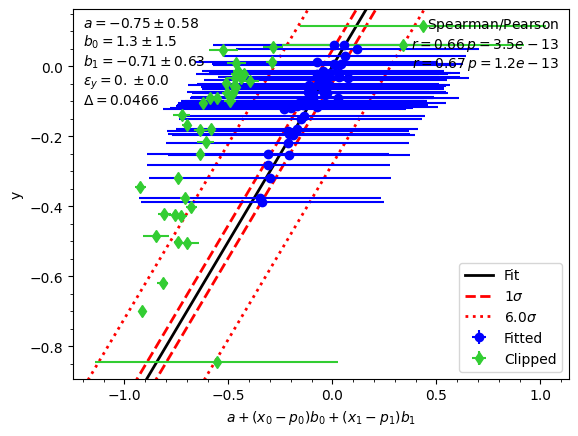

In [56]:
x1 = combined_table['log(sigma_1/2)']
x2 = combined_table['log(Sigma_1/2)']  # Already in log10
y = np.log10(combined_table["log(r_e)"])

x1_err = combined_table['sig_log(sigma_1/2)']
x2_err = combined_table['sig_log(Sigma_1/2)']
y_err = np.zeros_like(y)  # No error on r_e_V

#arrays
x1, x2, y = np.array(x1), np.array(x2), np.array(y)

x = np.column_stack([x1, x2])
sigx = np.column_stack([x1_err, x2_err])
sigy = y_err

p = ltsfit(x, y, sigx, sigy, corr=True, epsy=True, clip = 6,
           frac=None, label='Fitted',
           legend=True,plot=True, text=True)

print(f"Best fitting parameters: {p.coef}")
print(f"Scatter in log r_e: {p.sig_int} dex")
print(f"Scatter in r_e: {p.sig_int*np.log(10)*100:.2f}  +- {p.sig_int_err*np.log(10)*100:.2f} %")